## LAB<sup>7-6</sup> 다층 퍼셉트론으로 비선형 회귀 구현하기 (p.264)

**실습 목표**

퍼셉트론의 층을 증가시켜 아래와 같은 모델로 비선형 회귀를 구현해 보자. 적용할 데이터는 LAB<sup>6-1</sup>에서 사용한 것과 같이 다음 URL에 있는 데이터이다.

https://github.com/dknife/ML/raw/main/data/nonlinear.csv

### 1. 데이터를 읽어 들여서 확인해 보자. 이미 6장에서 사용해 본 데이터이다.

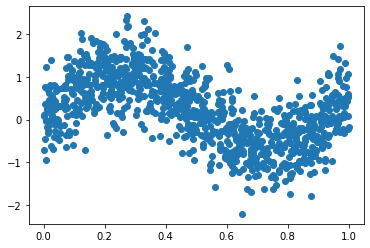

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data_loc = 'https://github.com/dknife/ML/raw/main/data/'
df = pd.read_csv(data_loc+'nonlinear.csv')
plt.scatter(df['x'], df['y'])

### 2. 각 계층의 노드 수는 입력, 은닉 계층 1, 은닉 계층 2, 출력 계층에서 각각 1개, 6개, 4개, 1개이다. 이를 변수로 지정하고, 필요한 연결강도를 난수로 생성한다. 각 연결강도 행렬의 크기는 연결하는 두 계층의 노드 수로 크기가 결정된다. 층이 하나 더 늘어 연결강도는 U, V, W가 필요하다. 학습률은 0.1로 잡아 보았다.

In [ ]:
nx, nh1, nh2, ny = 1, 6, 4, 1
U = np.random.randn(nx, nh1)*2
V = np.random.randn(nh1, nh2)*2
W = np.random.randn(nh2, ny)*2
learning_rate = 0.1

### 3. 활성화 함수는 여전히 시그모이드를 사용하자. 시그모이드의 미분 함수는 구현하지 않았는데 σ<sup>'</sup>(x) = σ(x)(1 - σ(x))이기 때문에 간단히 시그모이드의 결과만 가지고 미분치를 구할 수 있기 때문이다.

In [ ]:
def sigmoid(v):
  return 1 / (1 + np.exp(-v))

### 4. 앞의 실습에서는 합산 벡터, 오차 벡터 등을 모두 구했는데, 효율적인 코딩을 위해 노드의 출력, 미분, 델타 벡터만 준비하겠다. 각 벡터의 크기는 해당 계층의 노드 개수로 정해진다.

In [ ]:
input = np.zeros(nx)

h1_out, h1_deriv = np.zeros(nh1), np.zeros(nh1)   # 순전파시 계산 - 은닉계층 1
h1_delta         = np.zeros(nh1)                  # 역전파시 계산

h2_out, h2_deriv = np.zeros(nh2), np.zeros(nh2)   # 순전파시 계산 - 은닉계층 2
h2_delta         = np.zeros(nh2)                  # 역전파시 계산

y_out, y_deriv   = np.zeros(ny), np.zeros(ny)     # 순전파시 계산 - 출력계층
y_delta          = np.zeros(ny)                   # 역전파시 계산

### 5. 순전파를 단계별로 구하지 않고 시스템 전체로 구현하자.

In [ ]:
def forward(x):
  global input, h1_out, h1_deriv, h2_out, h2_deriv, y_out, y_deriv
  
  input = x

  h1_out   = sigmoid(U.T.dot(input))      # 은닉계층 1로 전파
  h1_deriv = h1_out * (1 - h1_out)        # 은닉계층 1의 미분

  h2_out   = sigmoid(V.T.dot(h1_out))     # 은닉계층 1로 전파
  h2_deriv = h2_out * (1 - h2_out)        # 은닉계층 1의 미분

  y_out    = sigmoid(W.T.dot(h2_out))     # 출력계층으로 전파
  y_deriv  = y_out * (1 - y_out)          # 출력계층의 미분

### 6. 오차는 출려과 목표값의 차이로 계산한다.

In [ ]:
def compute_error(target):
  return y_out - target

### 7. 역전파 과정도 오차를 입력하면 출력 계층까지 한 번에 이루어지게 구현하자.

In [ ]:
def backward(error):
  global y_delta, W, h2_delta, V, h1_delta, U

  y_delta = y_deriv * error                                 # 출력계층의 델타
  dW      = -learning_rate * np.outer(h2_out, y_delta)      # W의 수정
  
  W = W + dW
  h2_delta = h2_deriv * W.dot(y_delta)                      # 은닉계층 2의 델타
  dV       = -learning_rate * np.outer(h1_out, h2_delta)    # V의 수정

  V = V + dV
  h1_delta = h1_deriv * V.dot(h2_delta)                     # 은닉계층 1의 델타
  dU       = -learning_rate * np.outer(input, h1_delta)     # U의 수정

### 8. 훈련은 순전파를 실시하고, 오차를 구해 역전파를 실시한다. 매번 제곱 오차도 반환한다.

In [ ]:
def train(x, target):
  forward(x)
  e = compute_error(target)
  backward(e)
  return e**2

### 9. 읽어 들인 데이터에 'x'라는 이름의 열을 입력 데이터로 사용하고, 'y'라는 이름의 열은 **레이블**<sup>label</sup>로 사용하자. 이 두 데이터를 넘파이 배열로 만들어 차례로 훈련 함수에 넘긴다. 매 훈련 세트에 대한 훈련마다 오차를 누적해 loss 리스트에 기록한다.

In [ ]:
loss = []
X       = df['x'].to_numpy()
y_label = df['y'].to_numpy()

for i in range(100):
  e_accum = 0
  for x, y in zip(X, y_label):
    e_accum += train(x, y)
  loss.append(e_accum)

### 10. 오차를 그려 학습이 되는지 확인해 보자. 학습이 진핼될 수록 오차값도 작아진다.

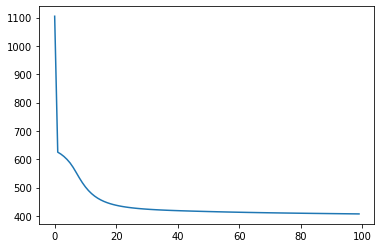

In [ ]:
err_log = np.array(loss).flatten()
plt.plot(err_log)
plt.show()

### 11. 입력 데이터를 받아 예측을 실시하는 predict() 함수를 만들어 보자. 여러 개의 입력이 리스트로 들어오면 하나씩 가져와 순전파를 실시하고, 출력을 저장한다.

In [ ]:
def predict(X):
  y_hat = []
  for x in X:
    forward(x)
    y_hat.append(y_out)
  return y_hat

### 12. 이제 0에서 1까지의 데이터를 생성해 이 모델에 입력으로 제공하여 얻는 예측치를 화면에 그려보자. 원래의 데이터와 예측 값을 비교하는 코드이다.

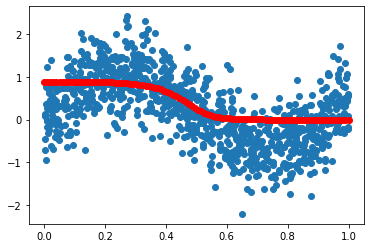

In [ ]:
domain = np.linspace(0, 1, 100).reshape(-1,1)   # 입력은 2차원 벡터로 변형

y_hat = predict(domain)
plt.scatter(df['x'], df['y'])
plt.scatter(domain, y_hat, color='r')

**잠깐 - 역전파 알고리즘은 신경망의 부활을 가져올까?**

1980년대에 신경망 분야는 역전파 알고리즘으로 활기를 되찾게 된다. 그런데 민스키는 역전파 알고리즘에 대해서도 퍼셉트론의 2판을 써서 다음과 같은 비판적인 의견을 내었다.

<small>_"많은 연결주의자들은 역전파가 단순히 기울기를 계산하는 특별한 방법에 불과하다는 것을 이해하지 못하고, 이것이 **언덕 오르기** 알고리즘의 기본적 한계를 극복하는 새로운 학습 기법이라 여기는 것 같다."_</small>

민스키의 지적대로 역전파가 마법은 아니지만, 신경망으로 해결할 수 있는 문제는 크게 확장되었다. 그런데, 신경망 분야는 금세 다시 침체에 빠지게 된다. 역전파가 무력해지는 경우가 많기 때문이다. 이 문제의 이유와 극복 과정이 앞으로 살펴볼 내용이다.